In [21]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# this_dir = os.path.dirname(os.path.abspath(__file__))
ECG_path = os.path.join("ECGData.mat")

ECG_data = sio.loadmat(ECG_path)

ECG_signal = np.double(ECG_data["m_Data"][0])[:2000]
sample_rate = ECG_data["s_Freq"][0][0]
time_array = np.arange(np.size(ECG_signal)) / sample_rate  # Time values
time_array = np.array(time_array)

In [23]:
initial_freq = 0
test_freq_lt = []
for i in range(len(ECG_signal)):
    freq = i * (sample_rate / len(ECG_signal))
    test_freq_lt.append(float(freq))

In [ ]:

fft_results = np.zeros(np.size(test_freq_lt), dtype=complex)

for i in tqdm(range(len(test_freq_lt))):
    x_test = np.exp(-1j * 2.0 * np.pi * test_freq_lt[i] * time_array)
    x_test = np.flip(x_test)

    fft_results[i] = np.convolve(
        ECG_signal, np.real(x_test), "valid"
    ) + 1j * np.convolve(ECG_signal, np.imag(x_test), "valid")

  0%|          | 0/76968 [00:00<?, ?it/s]C:\Users\tobon\AppData\Local\Temp\ipykernel_612\1253185511.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fft_results[i] = np.convolve(
 87%|████████▋ | 67036/76968 [09:32<02:46, 59.56it/s] 

In [ ]:
fft_gt = np.fft.fft(ECG_signal)

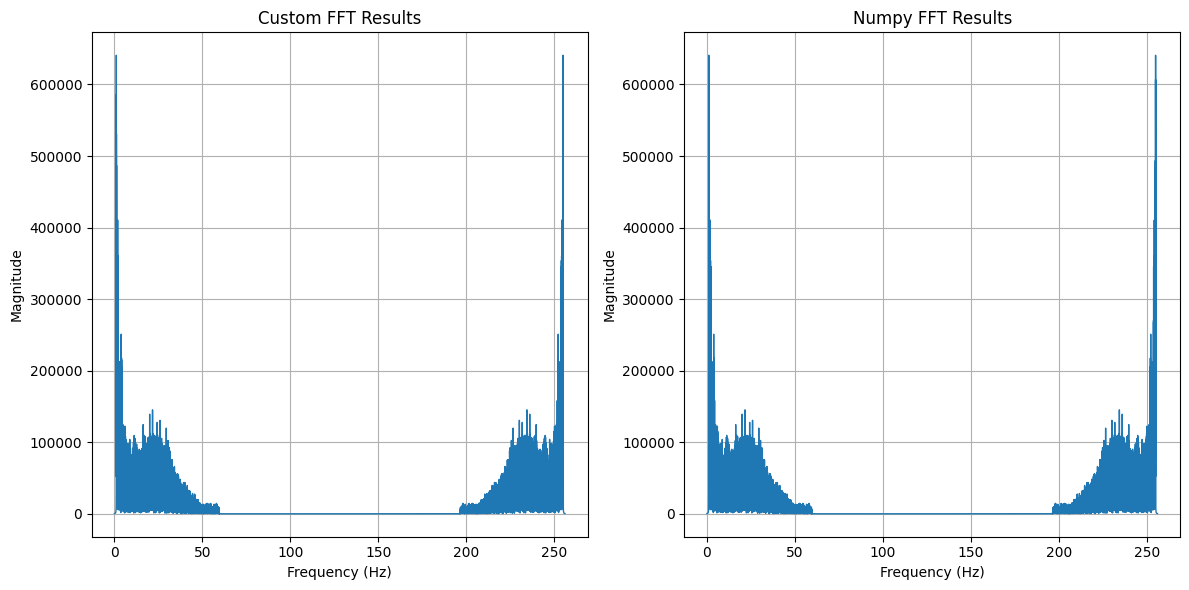

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(test_freq_lt, np.abs(fft_results), linewidth=1)
axs[0].set_title("Custom FFT Results")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Magnitude")
axs[0].grid(True)

axs[1].plot(test_freq_lt, np.abs(fft_gt), linewidth=1)
axs[1].set_title("Numpy FFT Results")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Magnitude")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
min_freq = 1
max_freq = 60

filtered_results = np.copy(np.array(fft_results))

for i in range(len(test_freq_lt)):
    if test_freq_lt[i] < min_freq or test_freq_lt[i] > max_freq:
        filtered_results[i] = 0

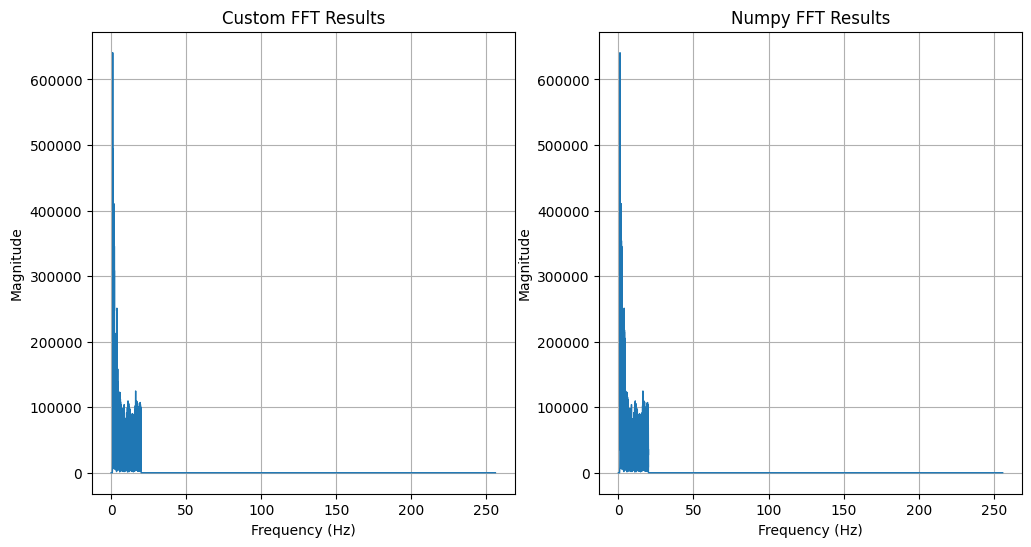

In [ ]:
plt.figure()
plt.plot(test_freq_lt, np.abs(filtered_results), linewidth=1)
plt.title("Filtered Results")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)

In [ ]:
ifft_results = np.zeros(np.size(filtered_results), dtype=complex)
for i in tqdm(range(len(filtered_results))):
    x_test = np.exp(1j * 2.0 * np.pi * filtered_results[i] * time_array)
    x_test = np.flip(x_test)

    ifft_results[i] = np.convolve(
        filtered_results, np.real(x_test), "valid"
    ) + 1j * np.convolve(filtered_results, np.imag(x_test), "valid")
    
ifft_results = (1 / len(ifft_results)) * ifft_results

  0%|          | 0/76968 [00:00<?, ?it/s]C:\Users\tobon\AppData\Local\Temp\ipykernel_612\2383648198.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ifft_results[i] = np.convolve(
100%|██████████| 76968/76968 [12:54<00:00, 99.35it/s] 


In [ ]:
ifft_gt = np.fft.ifft(fft_gt)

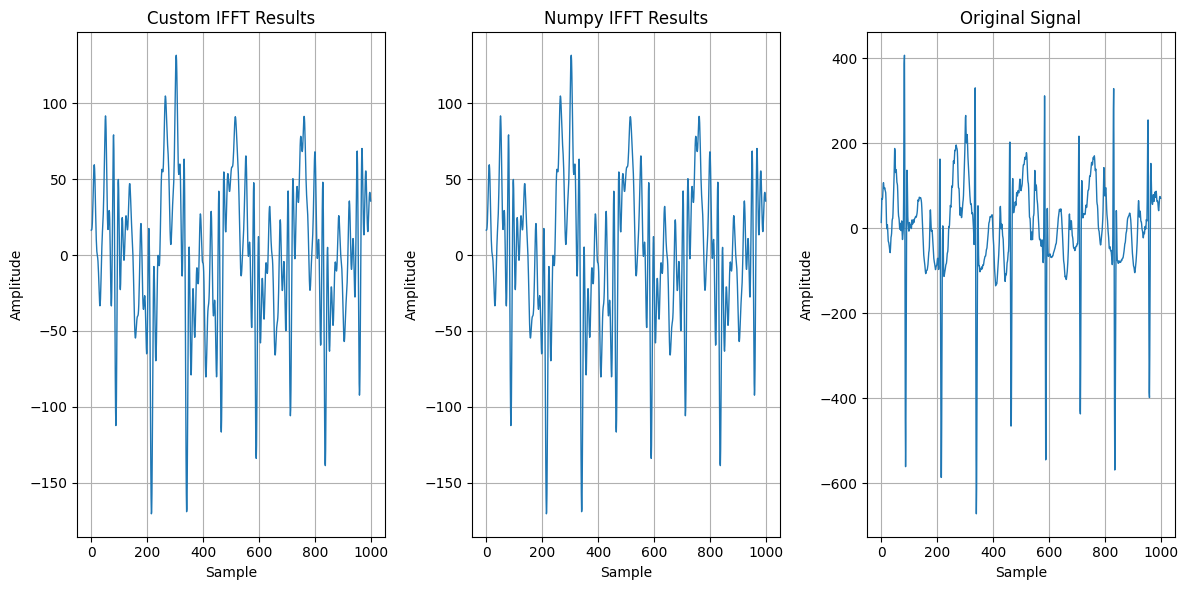

In [ ]:
data_len = 1000
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].plot(np.real(ifft_results[:data_len]), linewidth=1)
axs[0].set_title("Custom IFFT Results")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True)

axs[1].plot(np.real(ifft_gt[:data_len]), linewidth=1)
axs[1].set_title("Numpy IFFT Results")
axs[1].set_xlabel("Sample")
axs[1].set_ylabel("Amplitude")
axs[1].grid(True)

axs[2].plot(ECG_signal[:data_len], linewidth=1)
axs[2].set_title("Original Signal")
axs[2].set_xlabel("Sample")
axs[2].set_ylabel("Amplitude")
axs[2].grid(True)

plt.tight_layout()
plt.show()